

# Knowing MLPs



### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib

%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import sys
print(sys.executable)

/usr/bin/python3


### Step one: Using a PyTorch Dataset
Loading MNIST dataset from `torchvision.datasets`

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
testset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print(testset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
## Loading Training Data
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1)

## Loading Testing Data
testloader_minibatch = torch.utils.data.DataLoader(testset, batch_size=64)
testloader_stochastic = torch.utils.data.DataLoader(testset, batch_size=1)

In [4]:
from tqdm import tqdm
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<01:25, 10.95it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Defining a MLP Model 


In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [6]:
# Hyper-parameters 
input_size = 784 
hidden_size = 500 
num_classes = 10

learning_rate = 0.001

In [5]:
def trainAndTestModel(model,criterion,optimizer,num_epochs): ## After each epoch finding train and test lossi.e Network is getting trained for one epoch and then we are finding train and test loss based upon that

  train_losses = []
  test_losses = []

  n_total_steps = len(trainloader_minibatch)

  for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    for i, (images, labels) in enumerate(trainloader_minibatch):
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      
      # Forward Propogation
      outputs = model(images).to(device)

      # Calculating Loss
      loss = criterion(outputs, labels)
      
      # Backward Propogation
      loss.backward()

      # Updating the values for Loss and weights
      optimizer.step()

      # Making all gradients of optimiser to zero for the next batch
      optimizer.zero_grad()
      
      # if (i+1) % 100 == 0:
      #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      train_loss += loss.item()


    ##Finding train and test loss after each epoch 
    train_losses.append(train_loss/len(trainloader_minibatch))

    with torch.no_grad():
      for images, labels in testloader_minibatch:

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images).to(device)
        test_loss += criterion(output, labels).item()

      test_losses.append(test_loss/len(testloader_minibatch))

  ## Calculating accuracy after running on all epochs
  with torch.no_grad():

    n_correct = 0
    n_samples = len(testloader_minibatch.dataset)
    y_true = []
    y_pred = []

    for images, labels in testloader_minibatch:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images).to(device)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


    acc = n_correct / n_samples
    accuracy = acc*100
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy,f1,train_losses,test_losses
    

### Step four: Running the SimpleMLP using different optimizers and plotting train and test loss for each optimizer.


Reported final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [7]:
def plotTrainTestLosses(train_losses,test_losses,num_epochs):
  x = np.arange(start = 1,stop = num_epochs+1)
  plt.plot(x , train_losses ,  label='Train Loss')
  plt.plot(x , test_losses  , label='Test Loss')
  plt.legend()
  plt.title("Plot for Train/Test Loss")
  plt.show()

# 1. SGD OPTIMIZER

Accuracy for SGD optimizer is  90.39
F1 score for SGD optimizer is  0.9035204435547086


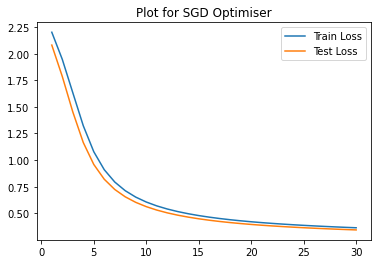

In [22]:

# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
# SGD OPTIMISER
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for SGD optimizer is ",accuracy)
print("F1 score for SGD optimizer is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

# 2. SGD WITH MOMENTUM OPTIMIZER

Accuracy for SGD WITH MOMENTUM optimizer is  93.33
F1 score for SGD WITH MOMENTUM optimizer is  0.9331956085178855


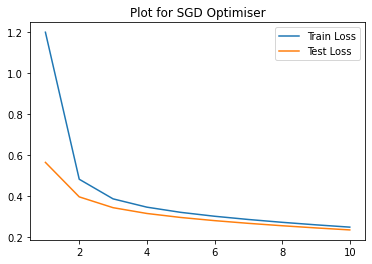

In [23]:
# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# OPTIMISER
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum = 0.9) 

accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for SGD WITH MOMENTUM optimizer is ",accuracy)
print("F1 score for SGD WITH MOMENTUM optimizer is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

# 3. SGD WITH L2 REGULARIZATION OPTIMIZER

Accuracy for SGDL2 optimizer is  90.33
F1 score for SGDL2 optimizer is  0.9029556334737399


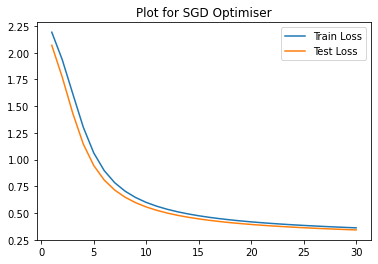

In [24]:
# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

# OPTIMISER
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay = 1e-4)

accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for SGDL2 optimizer is ",accuracy)
print("F1 score for SGDL2 optimizer is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

# 4. RMS PROP OPTIMIZER

Accuracy for RMSProp optimizer is  97.44
F1 score for RMSProp optimizer is  0.9743747719637302


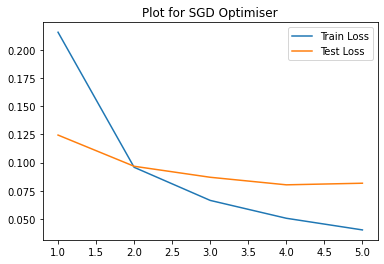

In [25]:
# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

# OPTIMISER
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate,weight_decay = 1e-4)  

accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for RMSProp optimizer is ",accuracy)
print("F1 score for RMSProp optimizer is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

# 5. ADAM OPTIMIZER

Accuracy for ADAM optimizer is  96.98
F1 score for ADAM optimizer is  0.9697784193387532


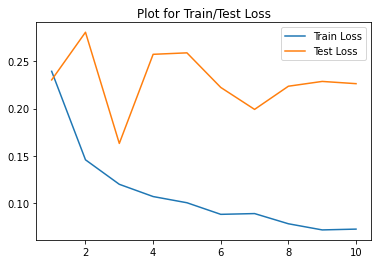

In [10]:
# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# OPTIMISER
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

accuracy,f1,train_losses_adam,test_losses_adam = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for ADAM optimizer is ",accuracy)
print("F1 score for ADAM optimizer is ",f1)
plotTrainTestLosses(train_losses_adam,test_losses_adam,num_epochs)

Stochastic Gradient Descent (SGD) is a straightforward optimizer that updates the parameters in the direction opposite to the gradient of the objective function.
SGD with Momentum improves upon SGD by incorporating momentum to smooth out updates, avoid local minima, and decrease high variance and fluctuations in irrelevant directions.
SGD with L2-Regularization adds L2 regularization to the SGD update step to combat overfitting and high variance.
Root Mean Square Propagation (RMSprop) is an optimizer that normalizes the parameter updates using a moving average of the squared gradients to ensure stability during training.
Adaptive Moment Estimation (Adam) is an optimizer that dynamically adjusts the learning rate for each parameter using both momentum and a moving average of the squared gradients to enhance convergence speed, avoid local minima, and prevent overfitting.






### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.


In [11]:
def trainAndTestLRModel(model,criterion,optimizer,num_epochs,scheduler):

  train_losses = []
  test_losses = []

  
  n_total_steps = len(trainloader_minibatch)

  for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    for i, (images, labels) in enumerate(trainloader_minibatch):
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      
      # Forward Propogation
      outputs = model(images).to(device)

      # Calculating Loss
      loss = criterion(outputs, labels)
      
      # Backward Propogation
      loss.backward()

      # Updating the values for Loss and weights
      optimizer.step()

      # Making all gradients of optimiser to zero for the next batch
      optimizer.zero_grad()
      
      # if (i+1) % 100 == 0:
      #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      train_loss += loss.item()

    train_losses.append(train_loss/len(trainloader_minibatch))
    scheduler.step()
    with torch.no_grad():
      for images, labels in testloader_minibatch:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images).to(device)
        test_loss += criterion(output, labels).item()

      test_losses.append(test_loss/len(testloader_minibatch))

  with torch.no_grad():

    n_correct = 0
    n_samples = len(testloader_minibatch.dataset)
    y_true = []
    y_pred = []

    for images, labels in testloader_minibatch:

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images).to(device)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


    acc = n_correct / n_samples
    accuracy = acc*100
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy,f1,train_losses,test_losses

## SimpleMLP and AdamOptimizer using Multiplicative and Multistep schedulers

Accuracy for ADAM optimizer using Multiplicative LR is  97.75
F1 score for ADAM optimizer using Multiplicative LR is  0.9774904522804654


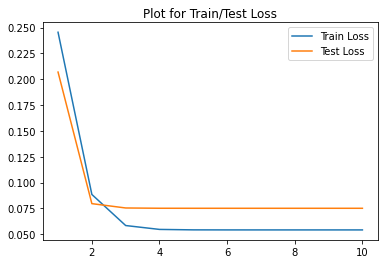

Accuracy for ADAM optimizer using Multistep LR is  97.84
F1 score for ADAM optimizer using Multistep LR is  0.9783883631461731


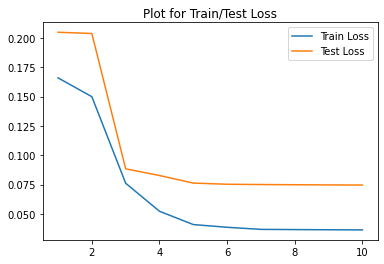

In [14]:
# Model and Criterion
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

#ADAM OPTIMISER(Multiplicative LR)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-4)
lambda_lr = lambda epoch: 0.1 ** (epoch // 1) 
scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)
accuracy,f1,train_losses_mult,test_losses_mult = trainAndTestLRModel(model,criterion,optimizer,num_epochs,scheduler)
print("Accuracy for ADAM optimizer using Multiplicative LR is ",accuracy)
print("F1 score for ADAM optimizer using Multiplicative LR is ",f1)
plotTrainTestLosses(train_losses_mult,test_losses_mult,num_epochs)

# ADAM OPTIMISER(Multistep LR)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.1)
accuracy,f1,train_losses_mstep,test_losses_mulstep = trainAndTestLRModel(model,criterion,optimizer,num_epochs,scheduler)
print("Accuracy for ADAM optimizer using Multistep LR is ",accuracy)
print("F1 score for ADAM optimizer using Multistep LR is ",f1)
plotTrainTestLosses(train_losses_mstep,test_losses_mulstep,num_epochs)


In [28]:
import pandas as pd
data = {
    'Epoch': range(1, 11),
    'SimpleMLP Train Loss': train_losses_adam,
    'SimpleMLP Test Loss': test_losses_adam,
    'MultiplicativeMLP Train Loss': train_losses_mult,
    'MultiplicativeMLP Test Loss': test_losses_mult,
    'MultistepMLP Train Loss': train_losses_mstep,
    'MultistepMLP Test Loss': test_losses_mulstep
}


# create a pandas dataframe with the data
df = pd.DataFrame(data)
print(df)

   Epoch  SimpleMLP Train Loss  SimpleMLP Test Loss  \
0      1              0.250265             0.240149   
1      2              0.163666             0.175936   
2      3              0.148340             0.173468   
3      4              0.138118             0.260745   
4      5              0.138843             0.211581   
5      6              0.137271             0.145880   
6      7              0.130336             0.211512   
7      8              0.130497             0.167194   
8      9              0.133913             0.169750   
9     10              0.130556             0.236095   

   MultiplicativeMLP Train Loss  MultiplicativeMLP Test Loss  \
0                      0.245455                     0.206899   
1                      0.088439                     0.079555   
2                      0.058365                     0.075359   
3                      0.054607                     0.075092   
4                      0.054176                     0.075067   
5         

## SOME COMPARISONS
Improved Convergence: A multiplicative LR scheduler can help the model converge faster and with better accuracy. This is because the LR is adjusted based on the progress of training, allowing the model to make smaller updates when it is close to convergence.

Lower learning rates: The multiplicative LR scheduler will reduce the learning rate over time, resulting in smaller updates to the model's parameters. This can lead to a more stable convergence and less overfitting.

### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

### Step seven: Training the above models and compare with SimpleMLP.

### 1ST MODEL -- BATCH NORMALISATION

In [12]:
class BatchNormMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,hidden_size3, num_classes):
        super(BatchNormMLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn2 = nn.BatchNorm1d(hidden_size3) 
        self.relu = nn.ReLU() 
        self.l4 = nn.Linear(hidden_size3, num_classes) 
    
    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.l4(out)
        return out

Accuracy for ADAM optimizer using Batch Normalization is  97.54
F1 score for ADAM optimizer using Batch Normalization is  0.9753946665539348


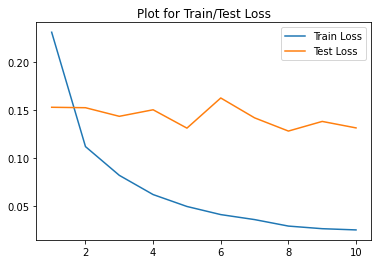

In [13]:
model = BatchNormMLP(input_size,500,400,300,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for ADAM optimizer using Batch Normalization is ",accuracy)
print("F1 score for ADAM optimizer using Batch Normalization is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

### 2ND MODEL --  DROPOUT

In [27]:
class DropoutMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DropoutMLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size2, num_classes) 
        self.dropout = nn.Dropout(p=0.4)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l3(out)
        return out

Accuracy for ADAM optimizer using Dropout is  92.05
F1 score for ADAM optimizer using Dropout is  0.9210636299740065


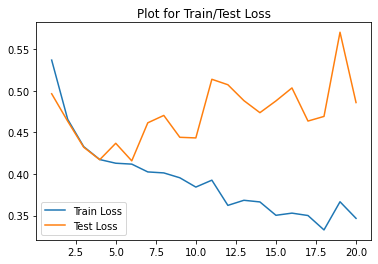

In [28]:
model = DropoutMLP(input_size,512,256,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for ADAM optimizer using Dropout is ",accuracy)
print("F1 score for ADAM optimizer using Dropout is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

### 3RD MODEL -- DROPOUT + BATCH NORMALISATION

In [22]:
class BatchDropoutMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,hidden_size3, num_classes):
        super(BatchDropoutMLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn2 = nn.BatchNorm1d(hidden_size3) 
        self.relu = nn.ReLU() 
        self.l4 = nn.Linear(hidden_size3, num_classes) 
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l3(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l4(out)
        return out

Accuracy for ADAM optimizer using Batch Normalization and Dropout is  95.92
F1 score for ADAM optimizer using Batch Normalization and Dropout is  0.9591742981003152


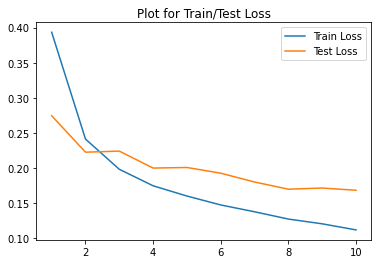

In [23]:
model = BatchDropoutMLP(input_size,500,300,100,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy,f1,train_losses,test_losses = trainAndTestModel(model,criterion,optimizer,num_epochs)
print("Accuracy for ADAM optimizer using Batch Normalization and Dropout is ",accuracy)
print("F1 score for ADAM optimizer using Batch Normalization and Dropout is ",f1)
plotTrainTestLosses(train_losses,test_losses,num_epochs)

## OBSERVATIONS
Overall, using Dropout and Batch Normalization with ADAM optimizer can lead to better generalization and more stable learning, but it may also make the model converge slower

Slower Convergence: Dropout and Batch Normalization can make the model converge slower than the model with only ADAM optimizer, especially if the model is large and complex. This is because Dropout and Batch Normalization introduce additional noise and randomness into the training process, which can make it harder for the model to find the optimal solution.

### Step eight: Mini-batch vs Stocastic


In [24]:
def trainAndTestLRModelSTOCHASTIC(model,criterion,optimizer,num_epochs,scheduler):

  train_losses = []
  test_losses = []

  
  n_total_steps = len(trainloader_stochastic)

  for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    for i, (images, labels) in enumerate(trainloader_stochastic):
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      
      # Forward Propogation
      outputs = model(images).to(device)

      # Calculating Loss
      loss = criterion(outputs, labels)
      
      # Backward Propogation
      loss.backward()

      # Updating the values for Loss and weights
      optimizer.step()

      # Making all gradients of optimiser to zero for the next batch
      optimizer.zero_grad()
      
      # if (i+1) % 100 == 0:
      #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      train_loss += loss.item()

    train_losses.append(train_loss/len(trainloader_stochastic))
    scheduler.step()
    with torch.no_grad():
      for images, labels in testloader_stochastic:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images).to(device)
        test_loss += criterion(output, labels).item()

      test_losses.append(test_loss/len(testloader_stochastic))

  with torch.no_grad():

    n_correct = 0
    n_samples = len(testloader_stochastic.dataset)
    y_true = []
    y_pred = []

    for images, labels in testloader_stochastic:

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images).to(device)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


    acc = n_correct / n_samples
    accuracy = acc*100
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy,f1,train_losses,test_losses

Accuracy(Minibatch) for ADAM optimizer using Multistep LR id  95.54
F1 score(Minibatch) for ADAM optimizer using Multistep LR is  0.955377220277229


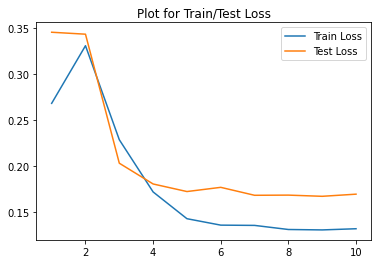

In [25]:
## ADAM optimizer with MultistepLR and taking Minibatch
learning_rate = 0.01
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.1)
accuracy,f1,train_losses_mstep,test_losses_mulstep = trainAndTestLRModel(model,criterion,optimizer,num_epochs,scheduler)
print("Accuracy(Minibatch) for ADAM optimizer using Multistep LR id ",accuracy)
print("F1 score(Minibatch) for ADAM optimizer using Multistep LR is ",f1)
plotTrainTestLosses(train_losses_mstep,test_losses_mulstep,num_epochs)




Accuracy(Stochastic) for ADAM optimizer using Multistep LR is  34.760000000000005
F1 score(Stochastic) for ADAM optimizer using Multistep LR is  0.3093156396904238


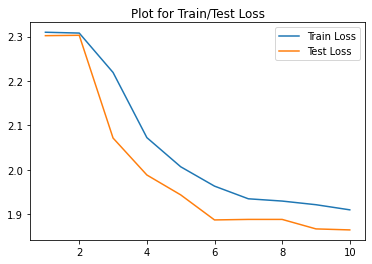

In [26]:
## ADAM optimizer with MultistepLR and taking Stochastic
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.1)
accuracy,f1,train_losses_mstep,test_losses_mulstep = trainAndTestLRModelSTOCHASTIC(model,criterion,optimizer,num_epochs,scheduler)
print("Accuracy(Stochastic) for ADAM optimizer using Multistep LR is ",accuracy)
print("F1 score(Stochastic) for ADAM optimizer using Multistep LR is ",f1)
plotTrainTestLosses(train_losses_mstep,test_losses_mulstep,num_epochs)

## Learnings

The main learning was kind of introduction to how to train a DEEP learning model, with different kinds of variations. I learn the use of various kinds of variations like Dropout , Batch Normalisation , and various kinds of optimizers with different schedulers.
Also the use of various variations has helped me to deep dive to various aspects of DL. Like I came to know the need of Batch Normalisation and Droupout. Overfitting is a major challenge which can be tackled using these.